# Phenotype acronym extraction

In [230]:
%load_ext autoreload
%autoreload 2

import sys
import cPickle
import numpy as np

# import snorkel and gwasdb
sys.path.append('../snorkel')
sys.path.append('../src')
sys.path.append('../src/crawler')

# set up paths
abstract_dir = '../data/db/papers'

# set up matplotlib
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load corpus

In [231]:
from snorkel.parser import XMLDocParser
from extractor.parser import UnicodeXMLTableDocParser

xml_parser = UnicodeXMLTableDocParser(
    path=abstract_dir,
    doc='./*',
    text='.//table',
    id='.//article-id[@pub-id-type="pmid"]/text()',
    keep_xml_tree=True)

In [236]:
from snorkel.parser import CorpusParser, OmniParser
import cPickle

table_parser = OmniParser()

corpus_name = 'gwas-table-corpus.pkl'
try:
    with open(corpus_name,"r") as pkl:
        corpus = cPickle.load(pkl)
except:
    cp = CorpusParser(xml_parser, table_parser, max_docs=100)
    %time corpus = cp.parse_corpus(name='GWAS Corpus')
    # pickling currently doesn't work...
#     with open(corpus_name,"w") as pkl:
#         corpus = cPickle.dump(corpus, pkl)

CPU times: user 3min 35s, sys: 12.7 s, total: 3min 48s
Wall time: 5min 35s


## Candidate extraction

### From tables

In [237]:
from snorkel.matchers import DictionaryMatch, Union, CellNameMatcher, CellDictNameMatcher
from snorkel.candidates import EntityExtractor
from snorkel.candidates import TableNgrams, CellSpace

# Define a candidate space
cells = CellSpace()

# Create a list of possible words that could denote phenotypes
acro_words = ['abbreviation', 'acronym', 'phenotype']
phen_words = ['trait', 'phenotype', 'description']

# Define matchers
phen_matcher = CellDictNameMatcher(axis='col', d=phen_words, n_max=3, ignore_case=True)
acro_matcher = CellDictNameMatcher(axis='col', d=acro_words, n_max=3, ignore_case=True)

phen_extractor = EntityExtractor(cells, phen_matcher)
acro_extractor = EntityExtractor(cells, acro_matcher)

In [238]:
from snorkel.candidates import AlignedTableRelationExtractor
relation_extractor = AlignedTableRelationExtractor(acro_extractor, phen_extractor, axis='row', induced=True)
tables = corpus.get_tables()

In [239]:
%time candidates = relation_extractor.extract(tables, name='all')
table_c = candidates
print "%s relations extracted, e.g." % len(table_c)
for cand in table_c[:5]: 
    print cand

CPU times: user 1min 59s, sys: 1.39 s, total: 2min 1s
Wall time: 2min 1s
96 relations extracted, e.g.
SpanPair(Span("CD40L", context=None, chars=[0,4], words=[0,0]), Span("CD40 Ligand, serum & plasma", context=None, chars=[0,26], words=[0,5]))
SpanPair(Span("CD40L", context=None, chars=[0,4], words=[0,0]), Span("2", context=None, chars=[0,0], words=[0,0]))
SpanPair(Span("CRP", context=None, chars=[0,2], words=[0,0]), Span("C-reactive protein", context=None, chars=[0,17], words=[0,1]))
SpanPair(Span("CRP", context=None, chars=[0,2], words=[0,0]), Span("5", context=None, chars=[0,0], words=[0,0]))
SpanPair(Span("ICAM1", context=None, chars=[0,4], words=[0,0]), Span("Intercellular adhesion molecule-1", context=None, chars=[0,32], words=[0,2]))


### From text

In [216]:
from snorkel.parser import SentenceParser, CorpusParser
from extractor.parser import UnicodeXMLDocParser, GWASXMLDocParser

xml_parser = GWASXMLDocParser(
    path=abstract_dir,
    doc='./*',
    title='.//front//article-title//text()',
    abstract='.//abstract//p//text()',
    n_par=5,
    id='.//article-id[@pub-id-type="pmid"]/text()',
    keep_xml_tree=True)

sent_parser = SentenceParser()
cp = CorpusParser(xml_parser, sent_parser, max_docs=15)
%time text_corpus = cp.parse_corpus(name='GWAS Text Corpus')

CPU times: user 1.19 s, sys: 73.1 ms, total: 1.26 s
Wall time: 7.66 s


In [217]:
from snorkel.candidates import Ngrams, CellSpace, TableNgrams
from snorkel.matchers import RegexMatchSpan
from snorkel.candidates import EntityExtractor, RelationExtractor, UnionExtractor

# Define a candidate space
ngrams8 = Ngrams(n_max=8)
ngrams3 = Ngrams(n_max=3)
cells = CellSpace()
table_ngrams3 = TableNgrams(n_max=3)

# Define matchers
phen_matcher = RegexMatchSpan(rgx=r'.+ \([a-zA-Z0-9_-]{1,10}[\);]')
acro_matcher = RegexMatchSpan(rgx=r'\([a-zA-Z0-9_-]{1,10}[\);]')

# Extractors
phen_txt_ngram_extractor = EntityExtractor(ngrams8, phen_matcher)
phen_txt_cells_extractor = EntityExtractor(cells, phen_matcher)
acro_txt_ngram_extractor = EntityExtractor(ngrams3, acro_matcher)
acro_txt_cells_extractor = EntityExtractor(table_ngrams3, acro_matcher)

# Filtering functions
def overlap_filter_fn(span0, span1):
    if hasattr(span0.context, 'cell') and hasattr(span1.context, 'cell'):
        if span0.context.cell != span1.context.cell: return False
    if len(span1.get_span().split()) >= 15: return False
    start0, end0 = span0.char_start, span0.char_end
    start1, end1 = span1.char_start, span1.char_end
    return True if start1 <= start0 <= end0 <= end1 else False

# Relation extractor
txt_tab_ngram_extractor = RelationExtractor(acro_txt_ngram_extractor, phen_txt_ngram_extractor, filter_fn=overlap_filter_fn)
txt_tab_cells_extractor = RelationExtractor(acro_txt_cells_extractor, phen_txt_cells_extractor, filter_fn=overlap_filter_fn)

Extract acroynms from tables

In [218]:
%time txt_tab_c = txt_tab_ngram_extractor.extract(corpus.get_phrases(), name='all')
print len(txt_tab_c), 'candidates extracted from text in tables'

CPU times: user 50.6 s, sys: 2.73 s, total: 53.3 s
Wall time: 1min 9s
19795 candidates extracted from text in tables


Extract acronyms from full table cells

In [219]:
%time txt_cel_c = txt_tab_cells_extractor.extract(corpus.get_tables(), name='all')
print len(txt_cel_c), 'candidates extracted from text in full table cells'

CPU times: user 1.72 ms, sys: 432 µs, total: 2.15 ms
Wall time: 2.3 ms
0 candidates extracted from text in full table cells


Extract acroynms from abstracts

In [220]:
%time txt_txt_c = txt_tab_ngram_extractor.extract(text_corpus.get_sentences(), name='all')
print len(txt_txt_c), 'candidates extracted from text in abstracts'

CPU times: user 2.28 s, sys: 39.3 ms, total: 2.32 s
Wall time: 2.34 s
884 candidates extracted from text in abstracts


## Learning the correctness of relations

In [184]:
from snorkel.candidates import UnionExtractor

contexts = [corpus.get_tables(), corpus.get_phrases(), text_corpus.get_sentences()]
extractors = [txt_tab_cells_extractor, txt_tab_ngram_extractor, txt_tab_ngram_extractor]
joint_extractor = UnionExtractor(extractor_list=extractors, context_list=contexts)
all_c = joint_extractor.union()
print len(all_c)

1288


### Creating a gold set

To create a gold set, we save all extracted relations into a csv file. We annotate it manually, and save the result to a second file. It contains pairs of phenotype and rsid strings; if that file exists, we take these as gold truth.

In [456]:
# store relations to annotate
with open('acronyms.unannotated.tsv', 'w') as f:
    for span_pair in all_c:
        doc_id = span_pair.span0.context.document.name
        str1 = span_pair.span0.get_span()
        str2 = span_pair.span1.get_span()
        if (doc_id, str1, str2) not in K: 
            if hasattr(span_pair.span1.context, 'cell'):
                print span_pair.span0.context.cell.text
                print span_pair.span0.get_span()
                print (doc_id, str1, str2), LF_full_cell(span_pair)
                print 
        try:
            f.write('%s\t%s\t%s\n' % (doc_id, str2, str1))
        except:
            continue

Physical Position (bp)†
Physical Position (bp)
('17903294', u'Physical Position (bp)', u'(bp)') 0

Physical Position (bp)†
Physical Position (bp)
('17903294', u'Physical Position (bp)', u'(bp)') 0

GEE p-val (Rank)††
GEE p-val (Rank)
('17903294', u'GEE p-val (Rank)', u'(Rank)') 0

Physical Position (bp)†
Physical Position (bp)
('17903294', u'Physical Position (bp)', u'(bp)') 0

Physical Position (bp)†
Physical Position (bp)
('17903294', u'Physical Position (bp)', u'(bp)') 0

GEE Pval (Rank)††
GEE Pval (Rank)
('17903294', u'GEE Pval (Rank)', u'(Rank)') 0

Physical Position (bp)†
Physical Position (bp)
('17903294', u'Physical Position (bp)', u'(bp)') 0

Physical Position (bp)†
Physical Position (bp)
('17903294', u'Physical Position (bp)', u'(bp)') 0

Total Cerebral Brain Volume (ATCBV)
Total Cerebral Brain Volume (ATCBV)
('17903297', u'Total Cerebral Brain Volume (ATCBV)', u'(ATCBV)') 1

Factor 1:Verbal Memory (F1)
Factor 1:Verbal Memory (F1)
('17903297', u'Factor 1:Verbal Memory (F1)', 

We now load the results of our annotation

In [44]:
annotations = dict()
with open('acronyms.anotated.txt') as f:
    text = f.read()
    for line in text.split('\r'):
        doc_id, str1, str2, res = line.strip().split('\t')
        res = 1 if int(res) == 1 else -1
        annotations[(doc_id, str2, str1)] = res

### Classifying table acronyms

In [221]:
from snorkel.features import TableNgramPairFeaturizer

pkl_f = 'acro_table_feats.pkl'
try:
    with open(pkl_f, 'rb') as f:
        featurizer = cPickle.load(f)
except:
    featurizer = TableNgramPairFeaturizer()
    featurizer.fit_transform(candidates)

Building feature index...
Extracting features...


In [222]:
def spair2uid(span_pair):
    doc_id = span_pair.span0.context.document.name
    str1 = span_pair.span0.get_span()
    str2 = span_pair.span1.get_span()
    return (doc_id, str1, str2)

# Split into train and test set
training_candidates = []
gold_candidates     = []
gold_labels         = []
n_half = len(candidates)/2
for c in candidates[:n_half]:
    uid = spair2uid(c)
    if uid in annotations:
        gold_candidates.append(c)
        gold_labels.append(annotations[uid])
    else:
        training_candidates.append(c)
training_candidates.extend(candidates[n_half:])
gold_labels = np.array(gold_labels)
print "Training set size: %s" % len(training_candidates)
print "Gold set size: %s" % len(gold_candidates)
print "Positive labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==1])
print "Negative labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==-1])
print "Positive labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==1])
print "Negative labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==-1])

Training set size: 0
Gold set size: 0
Positive labels in training set: 0
Negative labels in training set: 0
Positive labels in gold set: 0
Negative labels in gold set: 0


In [223]:
def LF1_digits(m):
    txt = m.span1.get_span()
    frac_num = len([ch for ch in txt if ch.isdigit()]) / float(len(txt))
    return -1 if frac_num > 0.5 else +1
def LF1_short(m):
    txt = m.span1.get_span()
    return -1 if len(txt) < 5 else 0

LF_tables = [LF1_digits, LF1_short]

In [224]:
from snorkel.snorkel import TrainingSet
from snorkel.features import NgramFeaturizer

training_set = TrainingSet(training_candidates, LF_tables, featurizer=TableNgramPairFeaturizer())

Applying LFs...
Featurizing...
Building feature index...
Extracting features...
LF Summary Statistics: 2 LFs applied to 0 candidates
------------------------------------------------------------
Coverage (candidates w/ > 0 labels):		nan%
Overlap (candidates w/ > 1 labels):		nan%
Conflict (candidates w/ conflicting labels):	nan%


ValueError: zero-size array to reduction operation minimum which has no identity

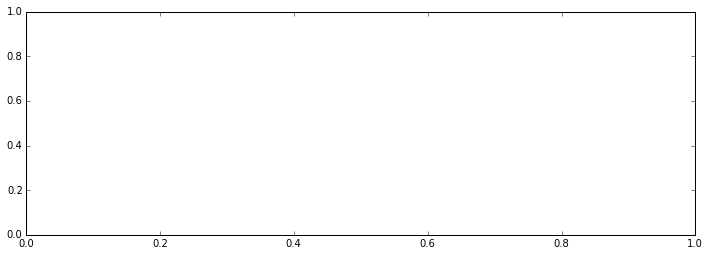

In [225]:
lf_stats = training_set.lf_stats()
lf_stats[:5]
lf_stats.hist("coverage")

In [ ]:
from snorkel.snorkel import Learner
import snorkel.learning
from snorkel.learning import LogReg

learner = Learner(training_set, model=LogReg())

# Splitting into CV and test set
n_half = len(gold_candidates)/2
test_candidates = gold_candidates[:n_half]
test_labels     = gold_labels[:n_half]
cv_candidates   = gold_candidates[n_half:]
cv_labels       = gold_labels[n_half:]

from snorkel.learning_utils import GridSearch
gs       = GridSearch(learner, ['mu', 'lf_w0'], [[1e-5, 1e-7],[1.0,2.0]])
gs_stats = gs.fit(cv_candidates, cv_labels)

In [ ]:
gs_stats

In [ ]:
learner.test_wmv(test_candidates, test_labels)

In [ ]:
preds = learner.predict_wmv(candidates)
resolved_acronyms = [spair2uid(c) for (c, p) in zip(candidates, preds) if p == 1]
print resolved_acronyms[:10]

In [ ]:
# mislabeled_cand = learner.mislabeled_test_candidates(test_candidates, test_labels)
# for (c,p,g) in mislabeled_cand[:10]:
#     print c.span0.context.document.name
#     print c.span0.context    
#     print c.span1.context
#     print

### Classifying sentence acronyms

In [ ]:
from snorkel.candidates import UnionExtractor
contexts = [corpus.get_tables(), corpus.get_phrases(), text_corpus.get_sentences()]
extractors = [txt_tab_cells_extractor, txt_tab_ngram_extractor, txt_tab_ngram_extractor]
joint_extractor = UnionExtractor(extractor_list=extractors, context_list=contexts)

text_c = joint_extractor.union()
print len(text_c)

In [ ]:
for c in text_c:
    if c.span0.context.document.name == '17903294':
        print unicode(c)

In [ ]:
# helpers
def spairtxt2uid(span_pair):
    doc_id = span_pair.span0.context.document.name
    str1 = span_pair.span1.get_span()
    str2 = span_pair.span0.get_span()
    acro = str2[1:-1]
    phen = str1.split(' (')[0]
    return (doc_id, acro, phen)

We really trust the first stage, so if an acronym has been resolved there, remove it from this stage

In [ ]:
new_text_c = list()
resolved = {(doc_id, acro) for doc_id, _, acro in resolved_acronyms}
for c in text_c:
    doc_id, phen, acro = spairtxt2uid(c)
#     print doc_id, phen, acro
    if (doc_id, acro) not in resolved:
        new_text_c.append(c)

print len(text_c), len(new_text_c)

In [ ]:
from snorkel.features import NgramPairFeaturizer

pkl_f = 'acro_text_feats.pkl'
try:
    with open(pkl_f, 'rb') as f:
        featurizer = cPickle.load(f)
except:
    featurizer = NgramPairFeaturizer()
    featurizer.fit_transform(text_c)

In [ ]:
# Split into train and test set
training_candidates = []
gold_candidates     = []
gold_labels         = []
n_half = len(text_c)/2
for c in text_c[:n_half]:
    uid = spair2uid(c)
    if uid in annotations:
        gold_candidates.append(c)
        gold_labels.append(annotations[uid])
    else:
        training_candidates.append(c)
training_candidates.extend(text_c[n_half:])
gold_labels = np.array(gold_labels)
print "Training set size: %s" % len(training_candidates)
print "Gold set size: %s" % len(gold_candidates)
print "Positive labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==1])
print "Negative labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==-1])
print "Positive labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==1])
print "Negative labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==-1])

In [ ]:
import re

# positive LFs
def LF_acro_matches(m):
    _, acro, phen = spairtxt2uid(m)
    words = phen.strip().split()
    if len(acro) == len(words):
        w_acro = ''.join([w[0] for w in words])
        if w_acro.lower() == acro.lower():
            return +1
    return 0

def LF_acro_matches_with_dashes(m):
    _, acro, phen = spairtxt2uid(m)
    words = re.split(' |-', phen)
    if len(acro) == len(words):
        w_acro = ''.join([w[0] for w in words])
        if w_acro.lower() == acro.lower():
            return +1
    return 0

def LF_acro_first_letter(m):
    _, acro, phen = spairtxt2uid(m)
    if not any(l.islower() for l in phen): return 0
    words = phen.strip().split()
    if len(acro) <= len(words):
        if words[0].lower() == acro[0].lower():
            return +1
    return 0

def LF_acro_prefix(m):
    _, acro, phen = spairtxt2uid(m)
    phen = phen.replace('-', '')
    if phen[:2].lower() == acro[:2].lower():
        return +1
    return 0

def LF_acro_matches_last_letters(m):
    _, acro, phen = spairtxt2uid(m)
    words = phen.strip().split()
    prev_words = m.span1.pre_window(d=1) + words
    w_prev_acro = ''.join([w[0] for w in prev_words])
    if w_prev_acro.lower() == acro.lower(): return 0
    for r in (1,2):
        new_acro = acro[r:]
        if len(new_acro) < 3: continue
        if len(new_acro) == len(words):
            w_acro = ''.join([w[0] for w in words])
            if w_acro.lower() == new_acro.lower():
                return +1
    return 0

def LF_full_cell(m):
    """If only phrase in cell is A B C (XYZ), then it's correct"""
    if not hasattr(m.span1.context, 'cell'): return 0
    return 1 if m.span1.context.cell.text == m.span1.get_span() else 0

def LF_start(m):
    punc = ',.;!?()\'"'
    if m.span1.get_word_start() == 0 or any(c in punc for c in m.span1.pre_window(d=1)):
        _, acro, phen = spairtxt2uid(m)
        if phen[0].lower() == acro[0].lower(): 
            return +1
    return 0

LF_txt_pos = [LF_acro_matches, LF_acro_matches_with_dashes, LF_acro_first_letter, LF_acro_prefix, LF_acro_matches_last_letters, LF_full_cell, LF_start]

# negative LFs
def LF_no_pos(m):
    return -1 if not any(LF(m) for LF in LF_txt_pos) else 0

def LF_short(m):
    _, acro, phen = spairtxt2uid(m)
    return -1 if len(acro) == 1 else 0

def LF_lc(m):
    _, acro, phen = spairtxt2uid(m)
    return -1 if all(l.islower() for l in acro) else 0

def LF_uc(m):
    _, acro, phen = spairtxt2uid(m)
    return -2 if not any(l.islower() for l in phen) else 0

def LF_punc(m):
    _, acro, phen = spairtxt2uid(m)
    punc = ',.;!?()'
    return -1 if any(c in punc for c in phen) else 0
    

LF_txt_neg = [LF_no_pos, LF_short, LF_lc, LF_uc, LF_punc]

LF_txt = LF_txt_pos + LF_txt_neg

In [ ]:
from snorkel.snorkel import TrainingSet
from snorkel.features import NgramFeaturizer

training_set = TrainingSet(training_candidates, LF_txt, featurizer=NgramPairFeaturizer())

In [ ]:
lf_stats = training_set.lf_stats()
lf_stats[:5]
lf_stats.hist("coverage")

In [ ]:
from snorkel.snorkel import Learner
import snorkel.learning
from snorkel.learning import LogReg

text_learner = Learner(training_set, model=LogReg())

# Splitting into CV and test set
n_half = len(gold_candidates)/2
test_candidates = gold_candidates[:n_half]
test_labels     = gold_labels[:n_half]
cv_candidates   = gold_candidates[n_half:]
cv_labels       = gold_labels[n_half:]

from snorkel.learning_utils import GridSearch
gs       = GridSearch(text_learner, ['mu', 'lf_w0'], [[1e-5, 1e-7],[1.0,2.0]])
gs_stats = gs.fit(cv_candidates, cv_labels)

In [ ]:
gs_stats

In [ ]:
text_learner.test_wmv(test_candidates, test_labels)

In [240]:
text_preds = text_learner.predict_wmv(text_c)
text_acronyms = [spairtxt2uid(c) for (c, p) in zip(text_c, text_preds) if p == 1]
print text_acronyms[:10]
mislabeled_cand = [(c,p, annotations.get(spair2uid(c), None)) for c, p in zip(text_c, text_preds) if p != annotations.get(spair2uid(c), p)]
for (c,p,g) in mislabeled_cand[:50]:
    _, phen, acro = spairtxt2uid(c)
    print c.span0.context.document.name, p, g
    print c.span0.context    
    print c.span0.get_span(), c.span1.get_span()
    print [LF(c) for LF in LF_txt]
    print

NameError: name 'phen_c' is not defined

In [ ]:
# punc=','
# for (c) in (text_c):
#     if c.span0.context.document.name != '17903294': continue
#     _, phen, acro = spairtxt2uid(c)
#     print c.span0.context.document.name
#     print c.span0.context    
#     print c.span0.get_span(), c.span1.get_span()
#     print [LF(c) for LF in LF_txt]
#     print

### Collect all the candidates

In [ ]:
table_preds = learner.predict_wmv(candidates)
table_acronyms = [spair2uid(c) for (c, p) in zip(candidates, preds) if p == 1]
print table_acronyms[:10]

text_preds = text_learner.predict_wmv(text_c)
text_acronyms = [spairtxt2uid(c) for (c, p) in zip(text_c, text_preds) if p == 1]
print text_acronyms[:10]

acronyms = table_acronyms + text_acronyms

In [ ]:
# store relations to annotate
with open('acronyms.extracted.tsv', 'w') as f:
    for doc_id, str1, str2 in acronyms:
        try:
            out = u'{}\t{}\t{}\n'.format(doc_id, unicode(str2), str1)
            f.write(out.encode("UTF-8"))
        except:
            print 'ERROR:', str1, str2